In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from astropy.stats import sigma_clip
from scipy.stats import iqr

from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as u
from copy import deepcopy

from multiprocessing import Pool
import emcee
from sigmacut import calcaverageclass

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

corrections = np.loadtxt('ps1_calspec_cor.txt')
calsources = pd.read_csv('../calibration/calspec_full.csv')

Configuration file not found:

    /Users/rri38/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [2]:
from dustmaps.config import config
config['data_dir'] = '/Users/rri38/Documents/work/data/dustmaps'

In [3]:
syn = np.load('current_caspec_mags.npy',allow_pickle=True).item()
syn = pd.DataFrame(syn)

good = []
for i in range(len(syn['name'])):
    if 'ngc6681' not in syn['name'].iloc[i]:
        good += [i]
good = np.array(good)
syn = syn.iloc[good]
gr = syn['g'].values-syn['r'].values
ind = (gr < 1) #& (gr >= 0.2)
syn = syn.iloc[ind]

In [4]:
def mag2flux(mag,zp=25):
    flux = 10**(-1/2.5*(mag-zp))
    return flux

def t_comp(c,mag):
    zp = 25
    g = mag2flux(mag['g'],zp)
    r = mag2flux(mag['r'],zp)
    i = mag2flux(mag['i'],zp)
    z = mag2flux(mag['z'],zp)
    y = mag2flux(mag['y'],zp)
    #fit = c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y + c[5]*(g-r)
    fit = (c[0]*g + c[1]*r + c[2]*i + c[3]*z + c[4]*y)*(g/i)**c[5]
    fit = -2.5*np.log10(fit) + zp
    return fit 

def t_minimizer(c,mag):
    k = mag['tess']
    fit = t_comp(c,mag)
    diff = abs(k-fit)
    res = np.nansum(diff)
    #print(res)
    return res


In [5]:
syn

,g,r,i,z,y,kep,tess,name
0,16.448833,16.824855,17.193941,17.469483,17.703807,16.787205,17.207572,hs2027_stis_005
1,9.278681,9.771373,10.171662,10.469041,10.688448,9.689357,10.184255,bd_75d325_stis_005
2,16.984610,17.193064,17.418678,17.571332,17.448099,17.171691,17.387602,sdss132811_stis_003
3,14.527466,13.733931,12.486512,11.917067,11.668695,13.262748,12.340525,hz43b_stis_005
4,7.962748,7.644969,7.559345,7.557648,7.557790,7.703916,7.576215,hd38949_stis_005
...,...,...,...,...,...,...,...,...
86,7.483706,7.563091,7.683774,7.763686,7.780774,7.569961,7.686185,hd2811_stis_002
87,20.219263,19.471891,17.180642,15.592554,14.568557,17.924898,15.953766,2m003618_stiswfcnic_003
88,16.211254,16.669703,17.047354,17.349198,17.574212,16.597501,17.069956,wd1657_343_stiswfcnic_003
89,12.225922,12.374392,12.560075,12.734734,12.875551,12.376653,12.590816,gj7541a_stis_004


In [5]:
c0 = [.259,0.498,0.177,0.068,0.033,.1]
#c0 = [.25,.25,.25,.25,1]
bds = [(0,2),(0,2),(0,2),(0,2),(0,2),(-100,100)]
res = minimize(t_minimizer,c0,args=(syn),bounds=bds)

In [6]:
res

      fun: 0.19440385215549938
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.0545524 , 2.52214552, 2.14812683, 3.78904215, 5.88787686,
       2.88653528])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1183
      nit: 60
     njev: 169
   status: 0
  success: True
        x: array([0.        , 0.25582823, 0.27609407, 0.35809516, 0.11244277,
       0.00049096])

In [7]:
test = t_comp(res.x,syn)
#test = r_comp(mc,syn)
kdiff = syn['tess']-test
gr = syn['g'].values-syn['r'].values
mask = ~sigma_clip(kdiff).mask
kdiff = kdiff[mask]

<IPython.core.display.Javascript object>


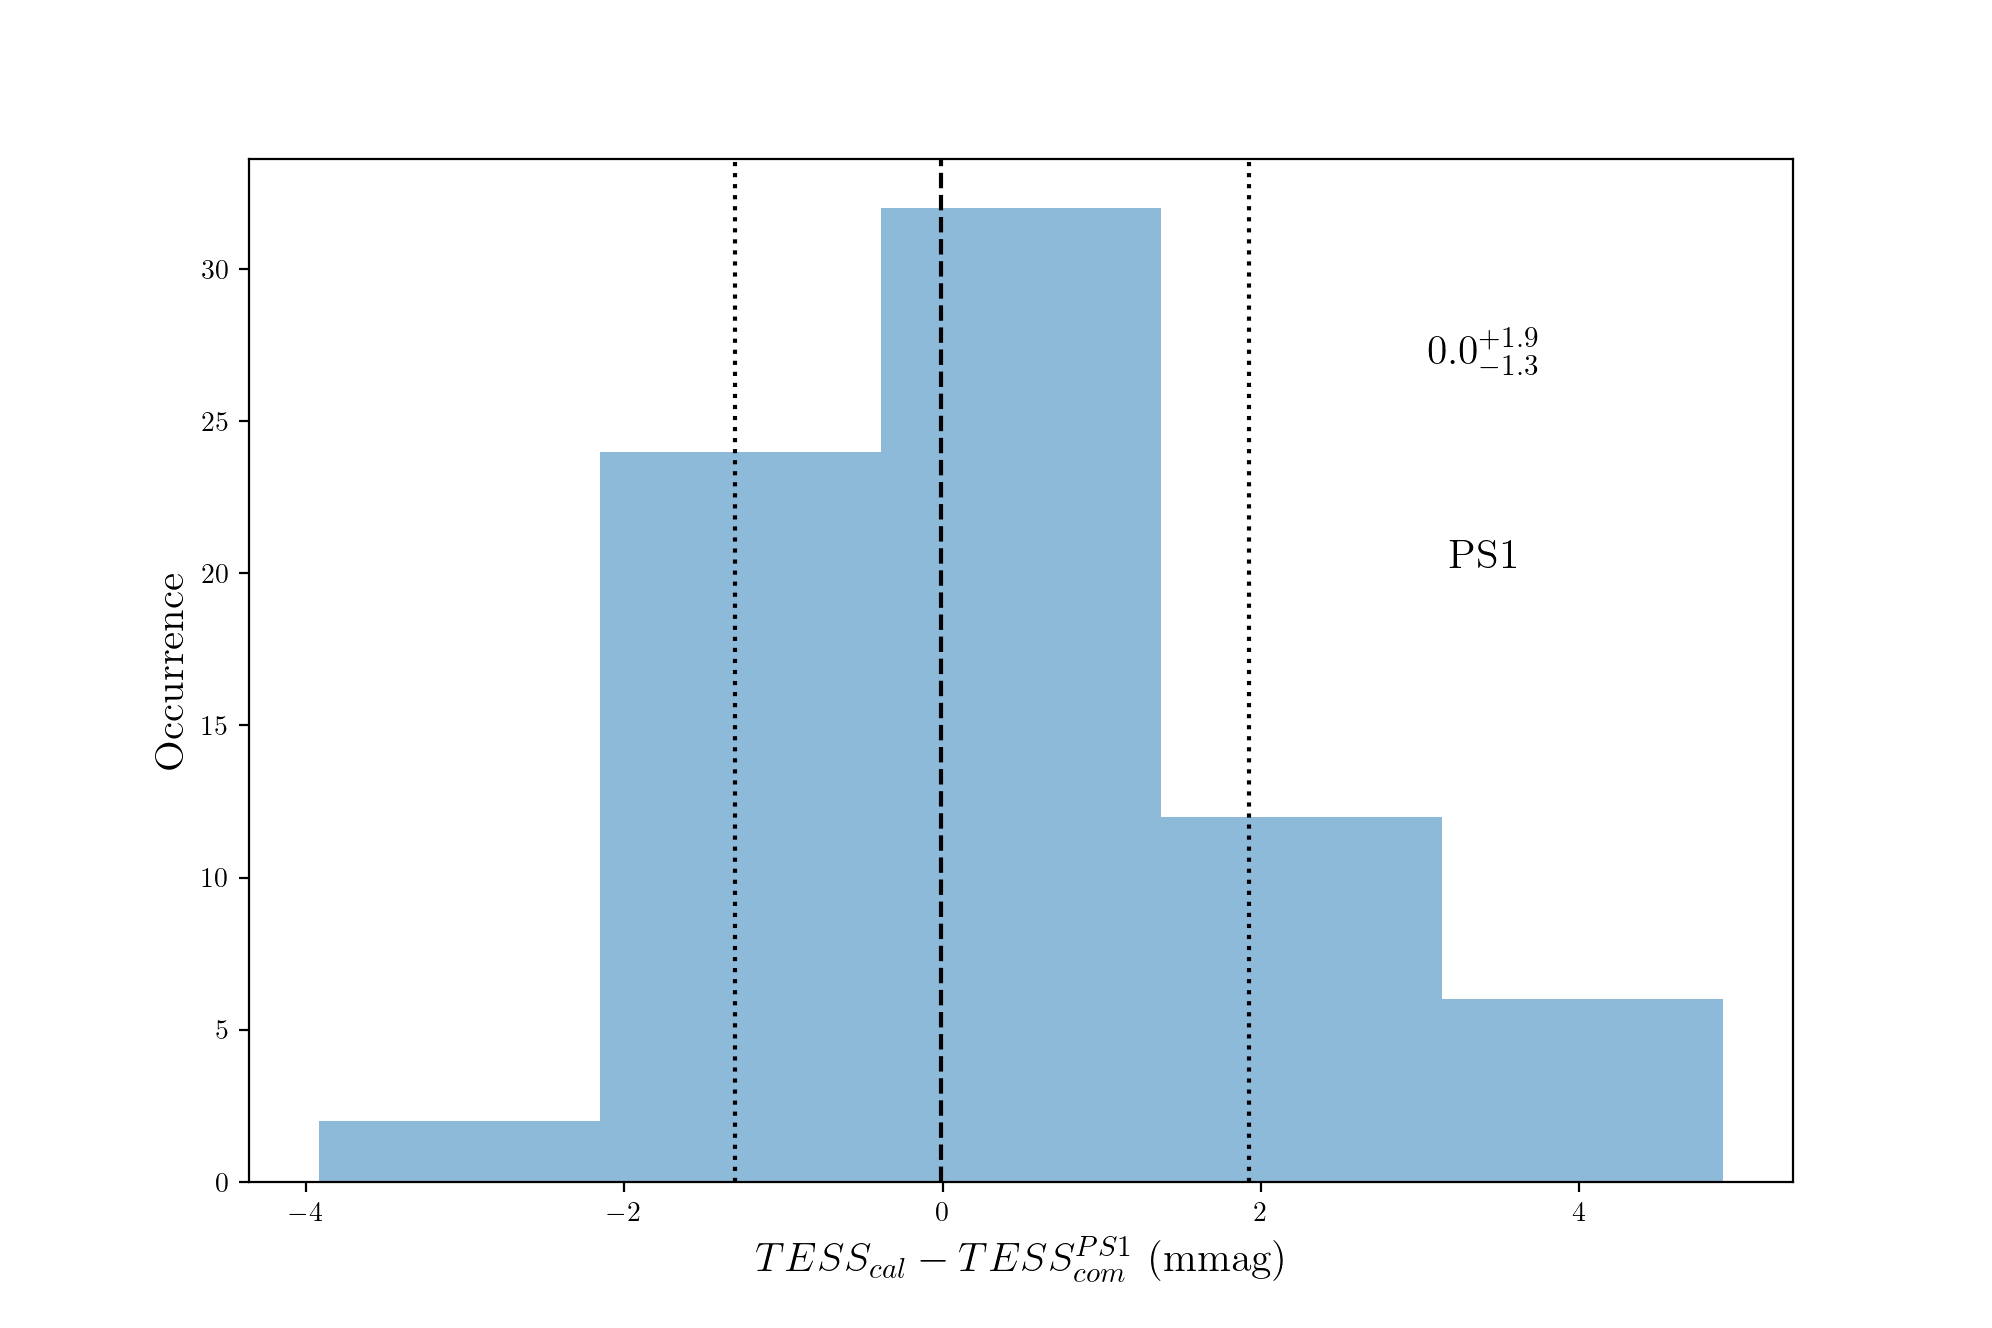

In [9]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
b = int(np.nanmax(kdiff) - np.nanmin(kdiff) /(2*iqr(kdiff)*len(kdiff)**(-1/3)))
plt.hist(kdiff*1e3,bins=5,alpha=0.5)
#plt.hist(control[mask]*1e3)
#plt.hist(kdiff[ind],bins=10)
med = np.percentile(kdiff*1e3,50)
low = np.percentile(kdiff*1e3,16)
high = np.percentile(kdiff*1e3,84)
plt.axvline(med,ls='--',color='k')
plt.axvline(low,ls=':',color='k')
plt.axvline(high,ls=':',color='k')

s = '$'+str(abs((np.round(med,0))))+'^{+' + str((np.round(high-med,1)))+'}_{'+str((np.round(low-med,1)))+'}$'
plt.annotate(s,(.8,.8),fontsize=15,xycoords='axes fraction', ha='center')
plt.annotate('PS1',(.80,.6),fontsize=15,xycoords='axes fraction', ha='center')

plt.xlabel(r'$TESS_{cal}-TESS^{PS1}_{com}$ (mmag)',fontsize=15)
plt.ylabel('Occurrence',fontsize=15)
plt.savefig('PS1_com_tess_res.pdf', bbox_inches = "tight")

In [102]:
np.nansum((kdiff)**2/np.std(kdiff)**2)/len(test)

0.924969395319366

# Example spec plot

In [6]:
from tools import *
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]

model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)



In [7]:
from glob import glob
path = '/Users/rri38/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

In [8]:
names[86]

'hd2811_stis_002'

<IPython.core.display.Javascript object>


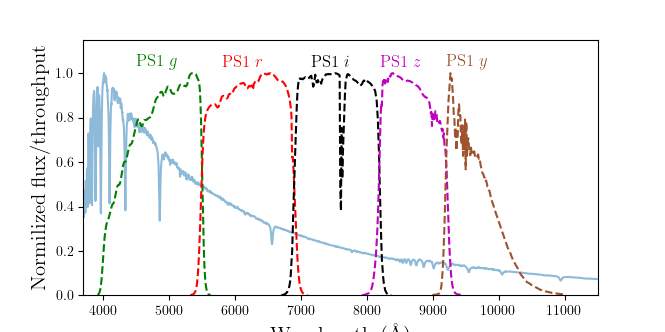

In [11]:
spec = np.loadtxt(files[86],skiprows=1,delimiter=',')

plt.figure(figsize=(2*fig_width,1*fig_width))
plt.plot(spec[:,0],spec[:,1]/np.nanmax(spec[:,1]),alpha=.5,label='SDSS spectra')
#ax = plt.gca().twinx()
#plt.fill_between(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='k',alpha=0.05)
#plt.plot(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='grey',label='$TESS$')



plt.plot(pbs['ps1g'][0].wave,pbs['ps1g'][0].throughput/np.nanmax(pbs['ps1g'][0].throughput),'g--',label='PS1 g')
plt.plot(pbs['ps1r'][0].wave,pbs['ps1r'][0].throughput/np.nanmax(pbs['ps1r'][0].throughput),'r--',label='PS1 r')
plt.plot(pbs['ps1i'][0].wave,pbs['ps1i'][0].throughput/np.nanmax(pbs['ps1i'][0].throughput),ls='--',color='k',label='PS1 i')
plt.plot(pbs['ps1z'][0].wave,pbs['ps1z'][0].throughput/np.nanmax(pbs['ps1z'][0].throughput),ls='--',color='m',label='PS1 z')
plt.plot(pbs['ps1y'][0].wave,pbs['ps1y'][0].throughput/np.nanmax(pbs['ps1y'][0].throughput),ls='--',color='sienna',label='PS1 y')

plt.text(4500,1.03,'PS1 $g$',color='g',fontsize=12)
plt.text(5800,1.03,'PS1 $r$',color='r',fontsize=12)
plt.text(7150,1.03,'PS1 $i$',color='k',fontsize=12)
plt.text(8200,1.03,'PS1 $z$',color='m',fontsize=12)
plt.text(9200,1.03,'PS1 $y$',color='sienna',fontsize=12)

#plt.legend(ncol=1, bbox_to_anchor=(1.01, .8))
#plt.legend(ncol=4,loc='center', bbox_to_anchor=(.5, 1.1))
plt.xlim(3700,11500)
plt.ylim(0,1.15)

plt.xlabel(r'Wavelength $(\rm \AA)$',fontsize=15)
plt.ylabel('Normilized flux/throughput',fontsize=15)
plt.savefig('ps1_filts_spec.pdf', bbox_inches = "tight")
#plt.savefig('calspec_spec_example_tess.pdf', bbox_inches = "tight")

In [24]:
np.where(syn['name'].values == names[86])

(array([76]),)

In [23]:
syn.iloc[76]

g              7.483706
r              7.563091
i              7.683774
z              7.763686
y              7.780774
kep            7.569961
tess           7.686185
name    hd2811_stis_002
Name: 86, dtype: object

In [25]:
! open .

In [5]:
gaia = np.loadtxt('/Users/rridden/Documents/work/data/filters/gaia/GAIA_GAIA0.G.dat')

In [17]:
gaia.shape

(362, 2)

<IPython.core.display.Javascript object>


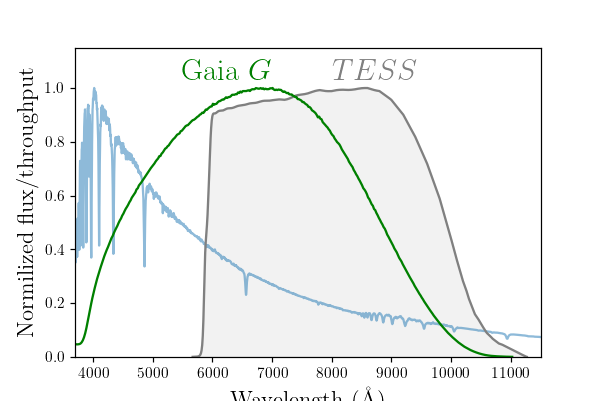

In [33]:
plt.figure(figsize=(1.5*fig_width,1*fig_width))
plt.plot(spec[:,0],spec[:,1]/np.nanmax(spec[:,1]),alpha=.5,label='SDSS spectra')
plt.fill_between(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='k',alpha=0.05)
plt.plot(pbs['tess'][0].wave,pbs['tess'][0].throughput/np.nanmax(pbs['tess'][0].throughput),color='grey',label='$TESS$')
plt.text(8000,1.03,'$TESS$',color='grey',fontsize=20)

plt.plot(gaia[:,0],gaia[:,1],'g')
plt.text(5500,1.03,'Gaia $G$',color='g',fontsize=20)


plt.xlim(3700,11500)
plt.ylim(0,1.15)

plt.xlabel(r'Wavelength $(\rm \AA)$',fontsize=15)
plt.ylabel('Normilized flux/throughput',fontsize=15)
plt.savefig('calspec_spec_gaia_tess.pdf', bbox_inches = "tight")